In [ ]:
''' Takes the dictionnary of all the transformed dataframes of all the periods,
then runs all the step of the stability analysis (KMeans) of the
clustering through time:
- Computes the cluster label of each customer of the 1st year for each period
- Computes ARI (clusters obtained with first period vs other periods)
- Computes flows between clusters
- Plots Sankey diagram
NB: two modes are available
method1: uses one model fitted on the data of the first year only
method2: refits the model on each new database
'''

def stability_through_time(dict_df_trans, n_clust, method1=True, method2=True):

    if method1:
        print("Method 1: Following customers of the first year with the \
same model (using .predict)")
        # Indexes of the customers of the first year
        ind_1st_year = dict_df_trans[0][0].index
        # Fitting the model on the database of the first year only
        model = KMeans(n_clusters=n_clust, random_state=14)
        model.fit(dict_df_trans[0][0])
        # Computing the cluster label of each customer of the 1st year for each period
        df_clust_1st_year = pd.DataFrame()
        for k, v in dict_df_trans.items():
            df_ = v[0] # database of period k
            name_ = v[1] # name of period k
            ser_clust = pd.Series(model.predict(df_),
                                index=df_.index,
                                name=f'{k}_clust_'+str(name_))
            ser = ser_clust.loc[ind_1st_year]
            df_clust_1st_year = pd.concat([df_clust_1st_year, ser.to_frame()],
                                        axis=1)
        nb_cust_1st_yr = df_clust_1st_year.shape[1]
        # Computing the ARI between the clusters obtained with first period and
        # each of the other periods (fitted once only)
        ser_ARI_1_month = \
            ARI_column_pairs(df_clust_1st_year,
                            first_vs_others=True, print_opt=False)
        # Plotting ARIs
        fig = plt.figure(figsize=(5,3))
        ax = fig.add_subplot(111)
        ax.plot(range(1, 14), ser_ARI_1_month.values, '-or')
        ax.set_xlabel('nb of extra months added')
        ax.set_ylabel('ARI (1st year as ref)')
        plt.title('Comparison of clusters labels (model fitted once)')
        plt.tight_layout()
        plt.show()
        # Computing flow data and plotting the Sankey diagram
        title="Sankey Diagram showing flows of customers from one period\
 to another - (model fitted once)"
        all_flows = plot_Sankey_diagram(df_clust_1st_year, title=title)

    if method2:
        print("Method 2: Following customers of the first year with the \
same model (using .predict)")
        # Computing the cluster label of each customer for each period
        # first initialisation
        init_kmeans = 'k-means++'
        df_clust_1st_year = pd.DataFrame()
        for k, v in dict_dfA_trans.items():
            df_ = v[0] # database of period k
            name_ = v[1] # name of period k
            n_init = 10 if k==0 else 1 # to avoid warning
            # initialisation of a new model with init using centroids of the last period
            model = KMeans(n_clusters=n_clust, init=init_kmeans,
                        n_init=n_init, random_state=14)
            # refitting the model for each period of time (with new customers)
            model.fit(df_)
            # computing cluster_centers for more accurate fitting on the next period
            init_kmeans = model.cluster_centers_
            # getting labels of all the customers of the period
            ser_clust = pd.Series(model.labels_,
                                index=df_.index,
                                name=f'{k}_clust_'+str(name_))
            # storing only labels of the customers of 1st year
            ser = ser_clust.loc[ind_1st_year]
            df_clust_1st_year = pd.concat([df_clust_1st_year, ser.to_frame()],
                                        axis=1)
        # Computing the ARI between the clusters obtained with first period and
        # each of the other periods (refit at each time)
        ser_ARI_1_month = ARI_column_pairs(df_clust_1st_year,
                                first_vs_others=True, print_opt=False)
        ser_ARI_1_month
        # Plotting ARIs
        fig = plt.figure(figsize=(5,3))
        ax = fig.add_subplot(111)
        ax.plot(range(1, 14), ser_ARI_1_month.values, '-ob')
        ax.set_xlabel('nb of extra months added')
        ax.set_ylabel('ARI (1st year as ref)')
        plt.title('Comparison of clusters labels (model re-fitted each time)')
        plt.tight_layout()
        plt.show()
        # Computing flow data and plotting the Sankey diagram
        title="Sankey Diagram showing flows of customers from one period to another\
        - (model re-fitted each time)"
        all_flows = plot_Sankey_diagram(df_clust_1st_year, title=title)

In [ ]:
''' Takes a dataset (df_expl) and the same dataset transformed prior
to clustering.
Then runs:
- visualisation of the distribution of the features
- evaluation of sampling relevancy
- optimisation of the number of cluster (10 iterations)
    o showing 4 clustering scores
    o showing population ratio
    o silhouette of each clusters
    o initialisation stability ARI (20 iterations)
-> asking the user for best number based on scores, population of clusters
and initialisation stability
-  cluster analysis
    o visualization of the clusters on PCA, UMAP, t-SNE projections
    o contingency tables
    o relative difference
'''

def kmeans_clustering_all_steps(df, df_expl):
    
    ################## SHOWING CLUSTERING DATASET ##################
    # Histograms of the untransformed data
    print('ooooooooooooo- UNTRANSFORMED DATA (df_expl) -ooooooooooooo')
    plot_histograms(df=df_expl, cols=df_expl.columns,
                    figsize=(12,15), bins=30, layout=(9,4))
    # Histograms of the transformed data
    print('ooooooooooooo- TRANSFORMED DATA (df) -ooooooooooooo')
    plot_histograms(df=df, cols=df.columns,
                    figsize=(12,15), bins=30, color='pink', layout=(9,4))

    ######################## SAMPLING RELEVANCY ########################
    # Choosing a model for sampling relevancy
    km_sampl = KMeans(n_clusters=6, random_state=14)
    km_sampl.fit(df)
    # Checking the ARI score between predictions of the "whole model"
    # vs. the "sample model", n_iter times.
    n_iter=10
    li_n_samp = [100, 250, 500, 750, 1000, 2000, 3000,
                4000, 5000, 7500, 10000, 20000, 50000]
    # Bining the mean review score column for further stratification (sampling)
    bin_mean_review = pd.cut(df_cust['mean_rev_score'], [0,1,2,3,4,5])
    df_ARI_all_vs_sample_iter = \
        check_ARI_through_sampling(km_sampl, df, li_n_samp, n_iter=n_iter,
                                   stratify=bin_mean_review, print_opt=False)
    # Plotting the results
    fig, ax = plt.subplots(1)
    fig.set_size_inches(13,5)
    ax.errorbar(li_n_samp,
                df_ARI_all_vs_sample_iter.mean(1).values,
                yerr=2*(df_ARI_all_vs_sample_iter.std(1).values),
                marker='o', color='blue')
    ax.tick_params(rotation=45)
    ax.set_xscale('log')
    plt.xlabel("Number of rows in the sample")
    plt.ylabel("ARI score")
    plt.title(f"Pred. of model fitted with the whole dataset \
    vs. pred. of model fitted with a sample ({n_iter}) iterations",
    fontweight='bold')
    plt.grid()
    plt.show()

    # Asking the user to enter the sample size
    sampl_size = int(input("Please, choose a convenient sample size: "))
    df_sampl, _ = train_test_split(df, train_size=sampl_size,
                                   stratify=bin_mean_review)
    ind_sampl = df_sampl.index

    ############## OPTIMISATION OF THE NUMBER OF CLUSTERS ##############
    # Reducing the size of the dataset
    df = df.loc[ind_sampl]
    df_expl = df_expl.loc[ind_sampl]
    # Choosing the number of clusters range
    list_n_clust = range(2,9)
    # Computes and returns:
    # - the aggregated results (mean, median, std) of the 4 scores
    # - the list of the clusters predicted for each iter. and nb of clusters
    # - the proportion (pct) of the clusters 
    dict_pkl_A = {}
    n_iter = 20
    dict_scores_iter, dict_ser_clust_n_clust, dict_pop_perc_n_clust = \
                        compute_clust_scores_nclust(df,
                                                    list_n_clust=list_n_clust,
                                                    n_iter=n_iter,
                                                    return_pop=True)
    # Plotting the 4 scores results              
    plot_scores_vs_n_clust(dict_scores_iter, figsize=(15,3))
    # Plotting the proportion of clusters (pies)
    plot_clust_prop_pie_vs_nclust(dict_pop_perc_n_clust,
                                list_n_clust, figsize=(15, 3))
    # Computing and plotting the silhouette score of each cluster
    silh_scores_vs_n_clust(df, n_clust=list_n_clust, proj='t-SNE',
                        xlim=(-0.1,1), figsize=(8,4),
                        palette='tab10')
    # Checking for initialisation stability of the clusters
    df_ARI_stab = pd.DataFrame()
    for i in list_n_clust:
        stab_init_kmeans = ARI_column_pairs(dict_ser_clust_n_clust[i],
                                            first_vs_others=False,
                                            print_opt=False)
        df_ARI_stab = pd.concat([df_ARI_stab, stab_init_kmeans.to_frame()],
                                axis=1)
    # Boxplot of the ARI score on multiples iterations
    df_ARI_stab.boxplot(color='red', vert=False)
    plt.gcf().set_size_inches(7,2.5)
    plt.title('Initialisation stability', fontweight='bold')
    plt.show()

    # Asking the user to enter the clusters number for the best model
    n_clust = int(input("Please, choose the number of\
     clusters for the best model: "))
    
    ########################### CLUSTERS ANALYSIS ###########################
    # Visualisation of the best clusters
    # fit the model on the whole dataframe
    best_model = KMeans(n_clusters=n_clust, random_state=14)
    best_model.fit(df)
    ser_clust = pd.Series(data=best_model.labels_,
                        index=df.index)
    silh = silhouette_score(X=df, labels=ser_clust)
    dav_bould = davies_bouldin_score(X=df, labels=ser_clust)
    cal_harab = calinski_harabasz_score(X=df, labels=ser_clust)
    distor = best_model.inertia_
    print(f"scores of the best model : \n silh={silh}, \
    cal_har={cal_harab}, dav_bould={dav_bould}, distor={distor}")
    # ----- plotting the clusters on PCA, UMAP and t-SNE projections -----
    fig = plt.figure(figsize=(12,3))
    tab_proj = ['PCA', 'UMAP', 't-SNE']
    for i, proj in enumerate(tab_proj,1):
        ax = fig.add_subplot(1,len(tab_proj), i)
        # plot only a sample, but using the model already fitted
        plot_projection(df, model=best_model, proj=proj,
                        fig=fig, ax=ax)
    fig.suptitle("Projection of the clusters of the best model",
                fontweight='bold', fontsize=14)
    fig.tight_layout(rect=[0,0,1,0.92])
    plt.show()
    ## ----- Contingency tables -----
    best_model.fit(df)
    ser_clust = pd.Series(best_model.labels_,
                            index=df.index,
                            name='clust')
    df_expl_quant = df_expl.select_dtypes(include=[np.number])
    ser_bin = pd.qcut(df_expl_quant[df_expl_quant.columns[0]],
                      [0,0.2,0.4,0.6,0.8,1],
                      precision=2, duplicates='drop')
    data_crosstab = pd.crosstab(ser_clust, ser_bin, margins = False)
    contingency_tables(best_model, df, df_expl, palette="mako",
                    cut_mode='quantile')
    ## ----- Relative difference to the mean -----
    clust_mean, orig_df_mean, rel_var = \
        mean_deviation_clust(best_model, df, df_expl.loc[df.index],
                             palette='seismic', figsize=(15,2))
    ## ----- Snake plot -----
    plot_snake(rel_var, thresh_dev=5)
    ## ----- ANOVA and Kruskal-Wallis -----
    # Computing ANOVA and Kruskal-Wallis for each features against clusters
    Anova_Kruskal_df = pd.DataFrame()
    for i, col in enumerate(df_expl.columns,1):
        ser = test_distrib_clust(df_expl.assign(clust=ser_clust), col,
                        'clust', print_opt=False)
        Anova_Kruskal_df = pd.concat([Anova_Kruskal_df, ser.to_frame()], axis=1)
    # Plotting the results
    fig, ax = plt.subplots(1)
    ser_anova = pd.Series([a for a,b in Anova_Kruskal_df.loc['ANOVA'].values],
                          index=Anova_Kruskal_df.loc['ANOVA'].index,
                          name='anova')
    ser_kruskal = pd.Series([a for a,b in \
                                Anova_Kruskal_df.loc['Kruskal-Wallis'].values],
                            index=Anova_Kruskal_df.loc['Kruskal-Wallis'].index,
                            name='kruskal')
    df_ = pd.concat([ser_anova, ser_kruskal], axis=1).sort_values('anova')

    (df_['anova'].sort_values()+1e-295).plot(marker='o', color='red',
                                             label='ANOVA', ax=ax)
    (df_['kruskal'].sort_values()+1e-295).plot(marker='o', color='blue',
                                               label='Kruskal-Wallis', ax=ax)
    ax.set_yscale('log')
    ax.set_xticklabels(df_.index)
    plt.xticks(rotation=45, ha='right')
    plt.xticks(np.arange(ser_anova.shape[0]))
    plt.title('p-value of the stat.hypothesis test\n (independence)',
            fontweight='bold', fontsize='14')
    plt.legend()
    plt.show()
    # Plotting boxplot of quantitative features for each cluster
    # NB: col_order -> to keep the order of the lower p-value first
    plot_boxplots_feat_vs_clust(df, df_expl, best_model, col_order=df_.index)
    ## ----- Radar charts -----
    ser_clust = best_model.labels_
    # DataFrame with the means of each columns for each cluster
    df_clust = df_expl.assign(clust=ser_clust)\
        .reindex(columns=['clust']+list(df_expl.columns))
    df_clust_mean = df_clust.groupby('clust').mean()
    # Plotting the radar chart (untransformed data)
    my_dpi = 96
    fig = plt.figure(figsize=(750/my_dpi, 500/my_dpi),
                    dpi=my_dpi)
    for i, row in enumerate(df_clust_mean.index, 1):
        ax = fig.add_subplot(3,3,i, polar=True)
        plot_radar_chart(df=df_clust_mean, row=row,
                         title='cluster '+str(row),
                         color=my_palette(row),
                         min_max_scaling=True, ax=ax)
    plt.tight_layout(rect=[0,0,1,0.95])
    ## ----- Decision Tree -----
    thresh_dev = 0
    sel_col = rel_var[np.abs(rel_var)>thresh_dev].dropna(how='all', axis=1).columns
    sel_col = [col for col in sel_col if not 'cat_' in col]
    df_dec_tree = df_clust[sel_col+['clust']]
    X_tr, y_tr = df_dec_tree.iloc[:,:-1], df_dec_tree.iloc[:,-1]
    # initializing and fitting the tree
    tree = DecisionTreeClassifier(max_depth=6, random_state=14)
    tree = tree.fit(X_tr, y_tr)
    feature_importances = pd.Series(tree.feature_importances_,
                                    index = df_dec_tree.iloc[:,:-1].columns,
                                    name='Feature importance')\
                                    .sort_values(ascending=False)
    # plotting main feature importance
    fig = plt.figure(figsize=(7, 3))
    ax = fig.add_subplot(111)
    n_feat = feature_importances.shape[0]
    ax.set_ylabel('Feature importance', fontsize=12)
    ax.set_title('Main feature importance (Decision Tree)',
                 fontsize=14, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.bar(range(n_feat), feature_importances, color='b', edgecolor='k')
    plt.xticks(range(n_feat), feature_importances.index,
               ha='right', rotation=45, fontsize=12)
    plt.show()

### Optimisation of Preparing the axes for visualisation

In [ ]:
# # TESTING FOR n_neighbors=15

# ind_sample = df_cust_trans.sample(1000, random_state=14).index

# fig = plt.figure(figsize=(18,3))
# n_neigh_list = [5, 10, 20, 50, 100, 200]
# for i, n in enumerate(n_neigh_list,1):
#     draw_umap(data=df,
#             #   ser_clust=ser_clust.loc[ind_sample],#
#               n_neighbors=n,
#               fig=fig,
#               layout=str(1)+str(len(n_neigh_list))+str(i),
#               title='n_neighbors = {}'.format(n),
#               s=1, alpha=0.6,
#               random_state=14)
# fig.suptitle("UMAP : Testing for best nb neighbors",
#              fontsize=16, fontweight='bold')
# plt.tight_layout(rect=[0,0,1,0.9])
# plt.show()

# # TESTING FOR min_dist=0.1

# fig = plt.figure(figsize=(18,3))
# min_dist_list = [0.0, 0.1, 0.25, 0.5, 0.8, 0.99]
# for i, d in enumerate(min_dist_list,1):
#     draw_umap(data=df,
#             #   ser_clust=ser_clust.loc[ind_sample],#
#               n_neighbors=100, min_dist=d,
#               fig=fig,
#               layout=str(1)+str(len(min_dist_list))+str(i),
#               title='min_dist = {}'.format(d),
#               s=1, alpha=0.6,
#               random_state=14)
# fig.suptitle("UMAP : Testing for best min distance",
#              fontsize=16, fontweight='bold')
# plt.tight_layout(rect=[0,0,1,0.9])
# plt.show()

In [ ]:
# # TESTING FOR n_components

# fig = plt.figure(figsize=(18,5))
# n_comp_list = [1,2,3]
# for i, a in enumerate(n_comp_list,1):
#     draw_umap(data=df_cust_trans.loc[ind_sample],
#             #   ser_clust=ser_clust.loc[ind_sample],#
#               n_neighbors=100, min_dist=0.8,
#               n_components=a,
#               fig=fig, layout=str(1)+str(len(n_comp_list))+str(i),
#               title='min_dist = {}'.format(a),
#               s=3, alpha=0.6,
#               random_state=14)
# fig.suptitle("UMAP : Testing for best min distance",
#              fontsize=16, fontweight='bold')
# plt.tight_layout(rect=[0,0,1,0.9])
# plt.show()

# OLD PREPROC

### 1.1 Aggregation of the customers dataset on custom time slots 

If we need to recompute the dataset in another period of time, we just need to call the function below, indicating as argument the right t_min and t_max.

In [ ]:
# Aggregation in a chosen time slot
# all customers (for max period of time): (96095, 22)

# t_min = pd.Timestamp('2017-10-17 17:30:18')
# t_max = pd.Timestamp('2018-01-01 17:30:18')

# def generate_cust_df(df_orders, t_min=None, t_max=None):
#     df_cust = create_agg_cust_df(df_orders, t_min=t_min, t_max=t_max)
#     df_cust = create_features_cust_df(df_cust)
#     return df_cust

# test_df_cust = generate_cust_df(df_orders, t_min=None, t_max=None)

In [ ]:
# df_cust.columns

Here we use a custom transformer (see the class CustTransformer in P5_functions.py) to:
- encode categorical data with Ordinal Encoder
- Standardize the quantitative data with StandardScaler

In [ ]:
# # Transformation and encoding
# ct = CustTransformer(strat_low_card='ohe',
#                      strat_quant='stand')
# ct.fit(df_cust)
# df_cust_trans = ct.transform(df_cust)

In [ ]:
# df_cust_trans.columns

### 1.2 Features selection, features reduction

#### Variance Inflation Factor

We'll use the variance inflation factor (VIF) to find the colinear features in our transformed dataset.
NB: the VIF of a feature among a group of features can be defined as 1/(1-R²), where R² is the R² score of a simple regression of this features over all the others. If R² is high (and hence VIF), it means that the feature can be very well approximated using one or more of the other features, and thus is the source of colinearity.
In the "select_from_vif_" function, we eliminate the most highly correlated features and recalculate VIF of each feature. Usually, VIF should not exceed 5.

In [ ]:
# select_from_vif_(df_cust_trans, thresh=0.5).columns

The columns exceeding a VIF of 5 are :
- low_card__cust_region_1', (the most frequent region)
- 'paytype_credit_card_tot_nb', (the most frequent payment)
- 'tot_comment_length', correlated with 'mean_comment_length'
- 'tot_nb_deliv_ord' and 'tot_nb_items', correlated resp. with 'tot_nb_ord' and - 'mean_nb_items_per_ord'
- 'mean_ship_delay', correlated with 'mean_ship_time'
- 'time_since_first_purch' correlated with 'time since_mast_purch'
- 'tot_price', 'tot_freight_val', 'tot_pay_value', mean_price_per_order', 'mean_pay_value_per_order', correlated with 'mean_nb_items_per_ord'

We decide to drop the foollowing columns:

In [ ]:
# col_vif_drop = ['time_since_first_purch', 'tot_comment_length',
#                 'tot_nb_deliv_ord', 'tot_nb_items', 'tot_pay_value',
#                 'paytype_credit_card_tot_nb', 'tot_freight_val',
#                 'mean_price_per_order', 'mean_pay_value_per_order',
#                 'mean_ship_delay']
# df_cust_vif = df_cust.drop(columns=col_vif_drop)
# df_cust_vif.shape

(96096, 33)

#### Low variance features

Checking for low variance features before transformation

In [ ]:
# # Transformation and encoding
# ct = CustTransformer(strat_low_card='ohe', # One_Hot enc for categorical
#                      strat_quant='none') # no standardization
# df_enc = ct.fit_transform(df_cust_vif)

# thresholds = [0,0.02,0.05,0.1,5,20,100,200,300,1000,5000,10000,25000,50000]

# df_feat_var = check_feature_variance(thresholds, df_enc)

In [ ]:
# plt.plot(df_feat_var['thresh']+0.0001, df_feat_var['n_rem_cols'],  '-or')

# ax = plt.gca()
# ax.set_xlabel('Variance threshold')
# ax.set_ylabel('Number of remaining columns')
# ax.set_xscale('log')
# # ax.set_yscale('log')

A lot of feature have low variance, but it is partially due to the scale of the data. Let's try several quantitative transformations to see if the variance of these data can be increased. 

In [ ]:
# # Transformation and encoding
# ct1 = CustTransformer(strat_low_card='ohe', # One_Hot enc for categorical
#                      strat_quant='none') # no transformation
# df_enc = ct1.fit_transform(df_cust_vif)

# print("------STANDARDIZATION-------")
# ct2 = CustTransformer(strat_binary='ord',
#                       strat_low_card='none', 
#                       strat_quant='stand') # Standardization
# df_enc_trans_A = ct2.fit_transform(df_enc)
# th_A = np.arange(0,1.05,0.05)
# df_res_A = check_feature_variance(th_A, df_enc_trans_A)

# print("------QUANTILE NORMALISATION (norm)-------")
# ct2 = CustTransformer(strat_binary='ord',
#                       strat_low_card='none', 
#                       strat_quant='quant_norm') # Standardization
# df_enc_trans_B = ct2.fit_transform(df_enc)
# th_B = np.arange(0,1.05,0.05)
# df_res_B = check_feature_variance(th_B, df_enc_trans_B)

# print("------QUANTILE NORMALISATION (unif)-------")
# ct2 = CustTransformer(strat_binary='ord',
#                       strat_low_card='none', 
#                       strat_quant='quant_uni') # Standardization
# df_enc_trans_C = ct2.fit_transform(df_enc)
# th_C = np.arange(0,0.2,0.01)
# df_res_C = check_feature_variance(th_C, df_enc_trans_C)

In [ ]:
# plt.plot(df_res_A['thresh']+0.0001, df_res_A['n_rem_cols'],
#          '-or', label='standardization', zorder=10)
# plt.plot(df_res_B['thresh']+0.0001, df_res_B['n_rem_cols'],
#          '-ob', label='quantile_trans(normal)', zorder=5)
# plt.plot(df_res_C['thresh']+0.0001, df_res_C['n_rem_cols'],
#          '-og', label='quantile_trans(uniform)', zorder=1)

# ax = plt.gca()
# ax.set_xlabel('Variance threshold')
# ax.set_ylabel('Number of remaining columns')
# # ax.set_xscale('log')
# ax.legend()
# # ax.set_yscale('log')
# plt.show()


Apart from 'mean_nb_items_per_ord' and 'single_purch, most of the low variance columns are, without surprise, dummy columns (region, payment type and category).
We will nevertheless keep the columns for the moment and try a feature selection.


#### PCA

In [ ]:
# # Data selection
# sel_cols = [c for c in df_cust_vif.columns \
#             if not (('cat_' in c)\
#                     or ('paytype' in c)\
#                     or ('reg' in c))]
# print("Columns excluded :\n",
#       [c for c in df_cust_vif if c not in sel_cols])
# print("Columns included :\n", sel_cols)

# # Transformation and encoding
# ct1 = CustTransformer(strat_low_card='ohe',
#                       strat_quant='quant_norm')
# ct2 = CustTransformer(strat_quant='stand')
# df_sel_trans = ct2.fit_transform(ct1.fit_transform(df_cust_vif[sel_cols]))

In [ ]:
# from sklearn.decomposition import PCA

# n_comp = len(df_sel_trans.columns)
# pca = PCA(n_components=n_comp).fit(df_sel_trans)

# # Performing pca
# pca_comp = pd.DataFrame(pca.components_,
#                         index=['PC'+str(i+1) for i in range(n_comp)],
#                         columns=sel_cols).T

# # Projection of the dataframe on all pca axes
# df_proj_PCA = pd.DataFrame(pca.transform(df_sel_trans),
#                            index=df_sel_trans.index,
#                            columns=['PC'+str(i) for i in range(n_comp)])

Plotting heat map of the principal components

In [ ]:
# plot_heatmap(pca_comp,'Principal components coefficients',
#              vmin=-1, vmax=1, center=0,
#              palette=sns.color_palette("coolwarm", 20),
#              figsize=(10,6),shape='rect')
# plt.show()

Plotting explained variance ratio in scree plot

In [ ]:
# exp_var_rat = pca.explained_variance_ratio_
# scree_plot(col_names= pca_comp.columns, exp_var_rat=exp_var_rat,
#            ylim=(0,0.6), figsize=(14,3))
# plt.grid()
# plt.show()

Without the dummy columns, 80% of the variance of the 15 columns is in the 8 first principal components.
With a quantile transformation (normal) before the standardization, more variance can be obtained on the first axes.

#### UMAP

In [ ]:
# # Data selection
# sel_cols = [c for c in df_cust_vif.columns \
#             if not (('cat_' in c)\
#                     or ('paytype' in c)\
#                     or ('reg' in c))]
# print("Columns excluded :\n",
#       [c for c in df_cust_vif if c not in sel_cols])
# print("Columns included :\n", sel_cols)

# # Transformation and encoding
# ct1 = CustTransformer(strat_low_card='ohe',
#                       strat_quant='quant_norm')
# ct2 = CustTransformer(strat_quant='stand')
# df_sel_trans = ct2.fit_transform(ct1.fit_transform(df_cust_vif[sel_cols]))

In [ ]:
# from umap import UMAP

# df = df_sel_trans

# n_comp = len(df.columns)

# # UMAP instantiation
# umap = UMAP(n_components=n_comp, n_neighbors=15, min_dist=0.1, init='spectral',
#             random_state=14)

# # Fitting the model, projecting data on UMAP axes
# df_proj_UMAP = pd.DataFrame(umap.fit_transform(df),
#                            index=df.index,
#                            columns=['UMAP'+str(i) for i in range(n_comp)])

In [ ]:
# # Sampling
# ind_samp_1000 = df_cust.sample(1000, random_state=14).index
# ind_samp_5000 = df_cust.sample(5000, random_state=14).index
# ind_samp_10000 = df_cust.sample(10000, random_state=14).index

In [ ]:
# vif_cols = [c for c in df_cust.columns if c not in df_cust_vif.columns]

In [ ]:
# cat_cols = [c for c in df_cust.columns if ('cat_' in c)]
# reg_cols = [c for c in df_cust.columns if ('reg' in c)]
# pay_cols = [c for c in df_cust.columns if ('paytype' in c)]+['mean_pay_install']

In [ ]:
# prod_spec_cols = ['mean_prod_vol_cm3', 'mean_prod_descr_length', 'mean_prod_wei_g',
#              'avg_freight_payval_ratio', 'mean_ship_delay', 'mean_ship_time']
# satisf_cols = ['mean_comment_length', 'tot_comment_length', 'mean_rev_score',
#                'nb_not_rec_orders']
# recency_cols = ['time_since_last_purch', 'time_since_first_purch']
# monetary_cols = ['mean_freight_val_per_order', 'tot_freight_val',
#                  'mean_price_per_order', 'tot_price',
#                  'avg_freight_payval_ratio', 'mean_pay_value_per_order',
#                  'tot_pay_value']
# frequency_cols = ['tot_nb_deliv_ord', 'tot_nb_ord', 'single_purch',
#                   'mean_nb_items_per_ord', 'tot_nb_items']  

In [ ]:
# all_cols = (list(set(cat_cols + reg_cols + pay_cols + vif_cols\
#                      + prod_spec_cols + satisf_cols + recency_cols\
#                      + monetary_cols + frequency_cols)))

In [ ]:
# len(df_cust.columns), len(all_cols),\
#     [c for c in df_cust.columns if c not in all_cols]

# OLD

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.cluster import KMeans

def clusters_ratio(df, n_clust, figsize=(15, 3)):
    fig = plt.figure(figsize=figsize)
    for i, k in enumerate(n_clust, 1):
        # Computing Kmeans with k clusters on scaled data
        km = KMeans(n_clusters=k)
        km.fit(df)
        # Computes cluster number (keeping original indices)
        ser_clust = pd.Series(km.labels_, index=df.index)

        # Compute pct of clients in each cluster
        pop_perc = 100 * ser_clust.value_counts() / df.shape[0]
        pop_perc.sort_index(inplace=True)

        ax = fig.add_subplot(str(1) + str(len(n_clust)) + str(i))
        ax.pie(pop_perc, autopct='%1.0f%%', pctdistance=0.5)
        ax.set_title(f'{str(k)} clusters')  # , pad=20
    fig.suptitle('Clusters ratio', fontsize=16, fontweight='bold')

In [ ]:
''' Computes Silhouette, Davies-Bouldin, Calinsky-Harabasz and inertia scores
for different number of clusters, then aggregate (mean std)
and plot the mean scores as a function of the number of clusters,
returns the aggregated scores as a dataframe'''

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def plot_clust_scores_vs_n_clust(df, n_clust=range(2,8),
                                 n_iter=10, figsize=(15,3)):

    silh_df, dav_bould_df, cal_harab_df, distor_df = \
        pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    # --- Looping on the number of clusters to compute the scores
    score_df_agg = pd.DataFrame()
    for i, n in enumerate(n_clust,1):
        silh, dav_bould, cal_harab, distor = [], [], [], []
        # Iterations of the same model (stability)
        for j in range(n_iter): 
            km = KMeans(n_clusters=n, n_jobs=-1)
            km.fit(df)
            ser_clust = pd.Series(data=km.labels_, index=df.index)
            # Computing scores for iterations
            silh.append(silhouette_score(X=df,
                                        labels=ser_clust))
            dav_bould.append(davies_bouldin_score(X=df,
                                        labels=ser_clust))
            cal_harab.append(calinski_harabasz_score(X=df,
                                        labels=ser_clust))
            distor.append(km.inertia_)                        
        # Dataframe of the results on iterations
        score_df = pd.DataFrame({'Silhouette': silh,
                                 'Davies_Bouldin': dav_bould,
                                 'Calinsky_Harabasz': cal_harab,
                                 'Distortion': distor})
        # --- Aggregation of the results
        ser_scores = score_df.agg(['mean', 'median', 'std']).unstack()\
                        .rename(n)
        score_df_agg = pd.concat([score_df_agg, ser_scores], axis=1)

    def gen_li(name): return [(name, s) for s in ('mean', 'median', 'std')]
    silh_df = score_df_agg.loc[gen_li('Silhouette')]
    dav_bould_df = score_df_agg.loc[gen_li('Davies_Bouldin')]
    cal_harab_df = score_df_agg.loc[gen_li('Calinsky_Harabasz')]
    distor_df = score_df_agg.loc[gen_li('Distortion')]

    # --- Plotting the results

    fig = plt.figure(figsize=figsize)

    def score_plot_vs_nb_clust(score_df, name, ax, c=None):
        score_df.T[(name,'mean')].plot(yerr=score_df.T[(name,'std')], elinewidth=1,
                            capsize=2, capthick=1, ecolor='k', fmt='-o',
                            c=c, ms=5, barsabove=False, uplims=False, ax=ax)
        
    ax = fig.add_subplot(141)
    score_plot_vs_nb_clust(silh_df,'Silhouette', ax, c='r')
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Silhouette score')

    ax = fig.add_subplot(142)
    score_plot_vs_nb_clust(dav_bould_df,'Davies_Bouldin', ax, c='b')
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Davies_Bouldin score')

    ax = fig.add_subplot(143)
    score_plot_vs_nb_clust(cal_harab_df,'Calinsky_Harabasz', ax, c='purple')
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Calinsky_Harabasz score')

    ax = fig.add_subplot(144)
    score_plot_vs_nb_clust(distor_df,'Distortion', ax, c='g')
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Distortion')

    fig.suptitle('Clustering score vs. number of clusters',
                fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

    return score_df_agg

In [ ]:
'''Computes the relative difference between the mean and the mean
of each clusters for each features of the original dataframe 
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.cluster import KMeans

def mean_dev_clust(model, df, orig_df, palette='seismic', figsize=(20, 3)):
    # Assign segment to each customer in original dataset
    data_with_clust = orig_df.assign(cluster=model.labels_)
    k = data_with_clust['cluster'].nunique()

    # Compute average for each feature by cluster
    kmeans_averages = data_with_clust.groupby(['cluster']).mean().round(2)
    print('Mean val for each cluster: ')
    display(kmeans_averages)
    print("\n")

    # Ratio of difference between mean and cluster means for each feature
    rel_variation = 100 * (kmeans_averages - orig_df.mean()) \
                    / (orig_df.mean() + 0.1)

    # Plotting figure
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(111)
    vlim = np.array([abs(rel_var.min().min()),
                     abs(rel_var.max().max())]).max()
    sns.heatmap(data=rel_variation,
                # vmin=-vlim, vmax=vlim,
                center=0, annot=True, fmt='.0f',
                cmap=palette, ax=ax1)
    ax1.set_title('Mean deviation to the mean (%)', pad=20)
    ax1.set_ylabel(ylabel='cluster', labelpad=20)
    return rel_variation

In [ ]:
from sklearn.metrics import adjusted_rand_score

def stability(model, df, n_iter=5, n_samp=10000):

    multiple_ser_clust = []
    for i in range(n_iter):
        model.fit(df)
        multiple_ser_clust.append(model.labels_)
    print("--- Testing for initialisation stability \
({} iterations) ---".format(n_iter))

    # Computes ARI scores for each pair of models
    ARI_scores = []
    pairs_list = combinlist(np.arange(n_iter),2)
    for i, j in pairs_list:
        ARI_scores.append(adjusted_rand_score(multiple_ser_clust[i],
                                              multiple_ser_clust[j]))

    # Compute the mean and standard deviation of ARI scores
    ARI_mean, ARI_std = np.mean(ARI_scores), np.std(ARI_scores)
    print("Evaluation of stability with random init :\n\
        mean:{:.1f} , std: {:.1f} ".format(ARI_mean, ARI_std))

    return ARI_scores


In [ ]:
''' Class that join a clustering algorithm to a classification algorithm
to be able to train the clustering algorithm on a sample and to predict
clusters labels on new unlearned data '''

from sklearn.base import BaseEstimator, clone
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.metaestimators import if_delegate_has_method

class InductiveClusterer(BaseEstimator):
    def __init__(self, clusterer, classifier):
        self.clusterer = clusterer
        self.classifier = classifier

    def fit(self, X, y=None):
        self.clusterer_ = clone(self.clusterer)
        self.classifier_ = clone(self.classifier)
        y = self.clusterer_.fit_predict(X)
        self.classifier_.fit(X, y)
        return self

    @if_delegate_has_method(delegate='classifier_')
    def predict(self, X):
        return self.classifier_.predict(X)

    @if_delegate_has_method(delegate='classifier_')
    def decision_function(self, X):
        return self.classifier_.decision_function(X)

In [ ]:

'''Computes the projection of the observations of df on the two first axes of
a transformation (PCA, UMAP or t-SNE)
The center option (clustering model needed) allows to project the centers
on the two axis for further display, and to return the fitted model
NB: if the model wa already fitted, does not refit.'''

from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.manifold import TSNE

def prepare_2D_axes(df, proj=['PCA', 'UMAP', 't-SNE'],
                    model=None, centers_on=False):

    dict_proj = dict()

    if centers_on:  # Compute and include the centers in the points
        model = model.fit(df) if not is_fitted(model) else model
        centers = model.cluster_centers_
        ind_centers = ["clust_" + str(i) for i in range(centers.shape[0])]
        centers_df = pd.DataFrame(centers,
                                  index=ind_centers,
                                  columns=df.columns)
        df = df.append(centers_df)

    ## Projection of all the points through the transformations

    # PCA
    if 'PCA' in proj:
        pca = PCA(n_components=2)
        df_proj_PCA_2D = pd.DataFrame(pca.fit_transform(df),
                                      index=df.index,
                                      columns=['PC' + str(i) for i in range(2)])
        dict_proj = dict({'PCA': df_proj_PCA_2D})

    # UMAP
    if 'UMAP' in proj:
        umap = UMAP(n_components=2, random_state=14)
        df_proj_UMAP_2D = pd.DataFrame(umap.fit_transform(df),
                                       index=df.index,
                                       columns=['UMAP' + str(i) for i in range(2)])
        dict_proj = dict({'UMAP': df_proj_UMAP_2D})

    # t-SNE
    if 't-SNE' in proj:
        tsne = TSNE(n_components=2, random_state=14)
        df_proj_tSNE_2D = pd.DataFrame(tsne.fit_transform(df),
                                       index=df.index,
                                       columns=['t-SNE' + str(i) for i in range(2)])
        dict_proj = dict({'t-SNE': df_proj_tSNE_2D})

    # Separate the clusters centers from the other points if center option in on
    if centers_on:
        dict_proj_centers = {}
        for name, df_proj in dict_proj.items():
            dict_proj_centers[name] = dict_proj[name].loc[ind_centers]
            dict_proj[name] = dict_proj[name].drop(index=ind_centers)
        return dict_proj, dict_proj_centers, model
    else:
        return dict_proj


In [ ]:

''' Plots the points on two axis (projection choice available : PCA, UMAP, t-SNE)
with clusters coloring if model available (grey if no model given).
NB: if the model wa already fitted, does not refit.'''


def plot_projection(df, model=None, proj='PCA', title=None,
                    figsize=(5, 3), palette='tab10', fig=None, ax=None):
    fig = plt.figure(figsize=figsize) if fig is None else fig
    ax = fig.add_subplot(111) if ax is None else ax

    # if model : computes clusters, clusters centers and plot with colors
    if not model is None:

        # Computes the axes for projection with centers
        # (uses fitted model if already fitted)
        dict_proj, dict_proj_centers, model = prepare_2D_axes(df,
                                                              proj=[proj],
                                                              model=model,
                                                              centers_on=True)
        # ...using model already fitted in prepare_2D_axes
        ser_clust = pd.Series(model.predict(df),
                              index=df.index,
                              name='Clust')

        n_clust = ser_clust.nunique()
        colors = sns.color_palette(palette, n_clust).as_hex()

        # Showing the points, cluster by cluster
        for i in range(n_clust):
            ind = ser_clust[ser_clust == i].index
            ax.scatter(dict_proj[proj].loc[ind].iloc[:, 0],
                       dict_proj[proj].loc[ind].iloc[:, 1],
                       s=1, alpha=0.7, c=colors[i])

            # Showing the clusters centers
            ax.scatter(dict_proj_centers[proj].iloc[:, 0].values[i],
                       dict_proj_centers[proj].iloc[:, 1].values[i],
                       marker='o', c=colors[i], alpha=1, s=150, edgecolor='k')
            # Showing the clusters centers labels
            ax.scatter(dict_proj_centers[proj].iloc[:, 0].values[i],
                       dict_proj_centers[proj].iloc[:, 1].values[i],
                       marker=r"$ {} $".format(str(i)),
                       c='k', alpha=1, s=70, )

        # # Showing the clusters centers
        # ax.scatter(dict_proj_centers[proj].iloc[:, 0],
        #            dict_proj_centers[proj].iloc[:, 1],
        #         #    marker='o',
        #            marker=r"$ {} $".format(str(i)),
        #            c=colors, alpha=1, s=100, edgecolor='k')


    # if no model, only plot points in grey
    else:
        # Computes the axes for projection without centers
        dict_proj = prepare_2D_axes(df,
                                    proj=[proj],
                                    centers_on=False)
        # Plotting the point in grey
        ax.scatter(dict_proj[proj].iloc[:, 0],
                   dict_proj[proj].iloc[:, 1],
                   s=1, alpha=0.7, c='grey')

    title = "Projection: " + proj if title is None else title
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('ax 1'), ax.set_ylabel('ax 2')

# A FINIR OU A REPRENDRE ...

In [ ]:
''' Takes the untransformed dataframe with clusters assigned
df_clust_mean: dataframe of the means for each feature (index=clusters) 
df_clust_std: dataframe of the standard deviation for each feature (index=clusters) 
ser_mean: series of means for each feature on the whole dataframe
'''

def plot_radar_chart_err(df_clust_mean, row, df_clust_std=None, df_mean=None, 
                         title=None, color='red', min_max_scaling=True, ax=None):

    df_clust_mean_ = df_clust_mean.copy('deep')
    if df_clust_std is not None: df_clust_std_ = df_clust_std.copy('deep')

    if min_max_scaling:
        min_max = MinMaxScaler()
        df_clust_mean_ = pd.DataFrame(min_max.fit_transform(df_clust_mean_.values),
                                     index=df_clust_mean_.index,
                                     columns=df_clust_mean_.columns)
        if df_clust_std is not None:
            df_clust_std_ = pd.DataFrame(min_max.transform(df_clust_std_.values),
                                        index=df_clust_std_.index,
                                        columns=df_clust_std_.columns)

    categories=list(df_clust_mean_.columns)
    df_clust_mean_ = df_clust_mean_.reset_index()
    if df_clust_std is not None:
        df_clust_std_ = df_clust_std_.reset_index()
    n_vars = len(categories)
    
    angles = [n / float(n_vars) * 2 * pi for n in range(n_vars)]
    angles += angles[:1] # "complete the loop"
    
    ax = plt.subplot(1,1,1, polar=True) if ax is None else ax
    
    # First axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    
    ax.set_rlabel_position(0)
    plt.yticks(color="grey", size=7)# [10,20,30], ["10","20","30"], 
    # plt.ylim(0,40)
    
    values = df_clust_mean_.loc[row].drop('clust').values
    values = np.append(values,values[:1])
    if df_clust_std is not None:
        std = df_clust_std_.loc[row].drop('clust').values
        std = np.append(std, std[:1])
        values_max = values + std
        values_min = values - std


    # plot the values
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    # ax.plot(angles, values_max, color='blue', linewidth=2, linestyle='dashed')
    # ax.plot(angles, values_min, color='green', linewidth=2, linestyle='dashed')
    ax.fill(angles, values, color=color, alpha=0.4)
    # plot 2 times std and fills between
    # ax.fill_between(angles, values) #color=color, linewidth=2, linestyle='solid')
    # plot the means values
    if title:
        plt.title(title, size=11, color=color, y=1.1, fontweight='bold')

# NEW

In [ ]:
''' For a each number of clusters in a list (list_n_clust),
- runs iterations (n_iter times) of a KMeans on a given dataframe,
- computes the 4 scores : silhouette, davies-bouldin, calinski_harabasz and
distortion
- if enabled only(return_pop): the proportion (pct) of the clusters
for each iteration and number of clusters
- and returns 3 dictionnaries:
    - dict_scores_iter: the 4 scores
    - dict_ser_clust_n_clust: the list of clusters labels for df rows
    - if enabled only (return_pop), dict_pop_perc_n_clust : the proportions

NB: the functions plot_scores_vs_n_clust and plot_prop_clust_vs_nclust plot
respectively the scores vs the number of clusters and the proportion of
clusters based on the dictionnaries provided by compute_clust_scores_nclust'''

def compute_clust_scores_nclust(df, list_n_clust=range(2,8),
                                 n_iter=10, return_pop=False):

    dict_pop_perc_n_clust = {}
    dict_ser_clust_n_clust = {}
    dict_scores_iter = {}

    # --- Looping on the number of clusters to compute the scores
    for i, n_clust in enumerate(list_n_clust,1):

        silh, dav_bould, cal_harab, distor = [], [], [], []
        pop_perc_iter, ser_clust_iter = pd.DataFrame(), pd.DataFrame()

        # Iterations of the same model (stability)
        for j in range(n_iter): 
            km = KMeans(n_clusters=n_clust, n_jobs=-1)
            km.fit(df)
            ser_clust = pd.Series(data=km.labels_,
                                  index=df.index, 
                                  name="iter_"+str(j))
            ser_clust_iter = pd.concat([ser_clust_iter, ser_clust.to_frame()],
                                       axis=1)

            if return_pop:
                # Compute pct of clients in each cluster
                pop_perc = 100 * ser_clust.value_counts() / df.shape[0]
                pop_perc.sort_index(inplace=True)
                pop_perc.index = ['clust_'+str(i) for i in pop_perc.index]
                pop_perc_iter = pd.concat([pop_perc_iter, pop_perc.to_frame()],
                                          axis=1)
        
            # Computing scores for iterations
            silh.append(silhouette_score(X=df, labels=ser_clust))
            dav_bould.append(davies_bouldin_score(X=df, labels=ser_clust))
            cal_harab.append(calinski_harabasz_score(X=df, labels=ser_clust))
            distor.append(km.inertia_)

        dict_ser_clust_n_clust[n_clust] = ser_clust_iter

        if return_pop:
            # dict of the population (pct) of clusters iterations
             dict_pop_perc_n_clust[n_clust] = pop_perc_iter.T

        # Dataframe of the results on iterations
        scores_iter = pd.DataFrame({'Silhouette': silh,
                                 'Davies_Bouldin': dav_bould,
                                 'Calinsky_Harabasz': cal_harab,
                                 'Distortion': distor})
        dict_scores_iter[n_clust] = scores_iter

    if return_pop:
        return dict_scores_iter, dict_ser_clust_n_clust, dict_pop_perc_n_clust
    else:
        return dict_scores_iter, dict_ser_clust_n_clust

In [ ]:
''' Plot the 4 mean scores stored in the dictionnary returned by the function
compute_clust_scores_nclust (dictionnary of dataframes of scores (columns)
for each iteration (rows) of the model and for each number of clusters
in a figure with error bars (2 sigmas)'''

def plot_scores_vs_n_clust(dict_scores_iter, figsize=(15,3)):

    fig = plt.figure(figsize=figsize)
    list_n_clust = list(dict_scores_iter.keys())

    # Generic fonction to unpack dictionary and plot one graph
    def score_plot_vs_nb_clust(scores_iter, name, ax, c=None):
        score_mean = [dict_scores_iter[i].mean().loc[n_score] for i in list_n_clust]
        score_std = np.array([dict_scores_iter[i].std().loc[n_score]\
                            for i in list_n_clust])
        ax.errorbar(list_n_clust, score_mean, yerr=2*score_std, elinewidth=1,
                capsize=2, capthick=1, ecolor='k', fmt='-o', c=c, ms=5,
                barsabove=False, uplims=False)

    li_scores = ['Silhouette', 'Davies_Bouldin',
                 'Calinsky_Harabasz', 'Distortion']
    li_colors = ['r', 'b', 'purple', 'g']

    # Looping on the 4 scores
    i=0
    for n_score, c in zip(li_scores, li_colors):
        i+=1
        ax = fig.add_subplot(1,4,i)
        
        score_plot_vs_nb_clust(dict_scores_iter, n_score, ax, c=c)
        ax.set_xlabel('Number of clusters')
        ax.set_ylabel(n_score+' score')

    fig.suptitle('Clustering score vs. number of clusters',
                fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

In [ ]:
''' Plot the proportion (%) of each cluster (columns) returned by the function
compute_clust_scores_nclust (dictionnary of dataframes of the proportion
for each iteration (rows) of the model in one figure with error bars (2 sigmas)'''

def plot_prop_clust_vs_nclust(dict_pop_perc_n_clust, figsize=(15,3)):

    fig = plt.figure(figsize=figsize)
    list_n_clust = list(dict_scores_iter.keys())

    for i, n_clust in enumerate(list_n_clust, 1):
        ax = fig.add_subplot(3,3,i)
        sns.stripplot(data=dict_pop_perc_n_clust[n_clust],
                      edgecolor='k', linewidth=1,  ax=ax)
        ax.set(ylim=(0,100))
        ax.set_ylabel("prop. of the clusters (%)")
    fig.suptitle(f"Proportion of the clusters through {n_iter} iterations",
                fontweight='bold', fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.97])

In [ ]:
""" Plot pies of the proportion of the clusters using the proportions
stored in the dictionnary returned by the function
'compute_clust_scores_nclust' (dictionnary of dataframes of the
proportions (columns) for each iteration (rows) of the model
and for each number of clusters in a figure with error (+/-2 sigmas)"""

def plot_clust_prop_pie_vs_nclust(dict_pop_perc_n_clust,
                                  list_n_clust, figsize=(15, 3)):

    fig = plt.figure(figsize=figsize)

    for i, n_clust in enumerate(list_n_clust,1):
        ax = fig.add_subplot(str(1) + str(len(list_n_clust)) + str(i))

        mean_ = dict_pop_perc_n_clust[n_clust].mean()
        std_ = dict_pop_perc_n_clust[n_clust].std()
        
        wedges, texts, autotexts = ax.pie(mean_,
                autopct='%1.0f%%',
                labels=["(+/-{:.0f})".format(i) for i in std_.values],
                pctdistance=0.5)
        plt.setp(autotexts, size=10, weight="bold")
        plt.setp(texts, size=8)
        ax.set_title(f'{str(n_clust)} clusters')  # , pad=20

    fig.suptitle('Clusters ratio', fontsize=16, fontweight='bold')
    plt.show()

In [ ]:
''' For each quantitative value of the original dataframe
(prior to transformation and clustering), returns two dataframes:
- the mean value for each clusters
- the relative difference of the means between clusters and whole dataframe '''

def mean_deviation_clust(model, df, orig_df, palette='seismic', figsize=(20, 3)):

    # Filters the numeric datas in 'orig_df'
    orig_df_quant = orig_df.select_dtypes(include=[np.number])
    model = model.fit(df) if not is_fitted(model) else model    

    # Assign segment to each customer in original dataset
    data_with_clust = orig_df_quant.assign(cluster=model.labels_)
    k = data_with_clust['cluster'].nunique()

    # Compute average for each feature by cluster
    clust_mean = data_with_clust.groupby(['cluster']).mean().round(2)

    # Ratio of difference between mean and cluster means for each feature
    orig_df_mean = orig_df_quant.mean()
    rel_var = 100 * (clust_mean - orig_df_mean) \
                    / (orig_df_mean + 0.1)

    # Plotting figure
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(111)
    vlim = np.array([abs(rel_var.min().min()),
                     abs(rel_var.max().max())]).max()
    sns.heatmap(data=rel_var,
                vmin=-vlim, vmax=vlim,
                center=0, annot=True, fmt='.0f',
                cmap=palette, ax=ax1)
    ax1.set_title('Mean deviation to the mean (%)', pad=20)
    ax1.set_ylabel(ylabel='cluster', labelpad=20)

    return clust_mean, orig_df_mean, rel_var

In [ ]:
# A REFONDRE EN UTILISANT LE DICTIONNAIRE dict_ser_clust_n_clust

def ARI_all_pairs(df_ser_clust_iter, first_vs_others=False):

    n_columns = len(df_ser_clust_iter.columns)
    n_clust = df_ser_clust_iter.stack().nunique()
    
    # Computes ARI scores for each pair of models
    ARI_scores = []
    if first_vs_others: # first columns versus the others
        pairs_list = [[0,i] for i in range(1,n_columns)]
        print("--- ARI between first and the {} others ---".format(n_columns-1))
        name = f'ARI_{str(n_clust)}_clust_first_vs_others'
    else: # all pairs
        pairs_list = combinlist(np.arange(n_columns),2)
        print("--- ARI all {} unique pairs ---".format(len(pairs_list)))
        name = f'ARI_{str(n_clust)}_clust_all_pairs'

    for i, j in pairs_list:
        ARI_scores.append(adjusted_rand_score(df_ser_clust_iter.iloc[:,i],
                                              df_ser_clust_iter.iloc[:,j]))

    # Compute the mean and standard deviation of ARI scores
    ARI_mean, ARI_std = np.mean(ARI_scores), np.std(ARI_scores)
    ARI_min, ARI_max = np.min(ARI_scores), np.max(ARI_scores)
    print("Evaluation of stability with random init :\n\
            ARI: mean={:.3f}, std={:.3f}, min={:.3f}, max={:.3f} "\
            .format(ARI_mean, ARI_std, ARI_min, ARI_max))

    return pd.Series(ARI_scores, index=pd.Index(pairs_list),
                     name=name)

In [ ]:
''' Plots a radar chart of the cluster profiles from a dataframe containing:
- the name or number of cluster as index
- the means of each features per clusters in columns
OR
- the value of each features for each cluster center (centroid)
NB: the values are almost the same

Values are scaled using a MinMaxScaler'''

from sklearn.preprocessing import MinMaxScaler
 
def plot_radar_chart(df, row, title, color, min_max_scaling=False, ax=None):

    df_copy = df.copy('deep')
    if min_max_scaling:
        min_max = MinMaxScaler()
        df_copy = pd.DataFrame(min_max.fit_transform(df_copy),
                               index=df_copy.index,
                               columns=df_copy.columns)
    df_ = df_copy.reset_index()
    categories=list(df)
    n_vars = len(categories)
    
    angles = [n / float(N) * 2 * pi for n in range(n_vars)]
    angles += angles[:1] # "complete the loop"
    
    ax = plt.subplot(1,1,1, polar=True) if ax is None else ax
    
    # First axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    
    ax.set_rlabel_position(0)
    plt.yticks(color="grey", size=7)# [10,20,30], ["10","20","30"], 
    # plt.ylim(0,40)
    
    values=df_.loc[row].drop('clust').values.flatten().tolist() # 
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    
    plt.title(title, size=11, color=color, y=1.1,
              fontweight='bold')

In [ ]:
import plotly.graph_objects as go
import urllib, json

url = 'https://raw.githubusercontent.com/plotly/plotly.js/master/test/image/mocks/sankey_energy.json'
response = urllib.request.urlopen(url)
data = json.loads(response.read())

# override gray link colors with 'source' colors
opacity = 0.4
# change 'magenta' to its 'rgba' value to add opacity
data['data'][0]['node']['color'] = ['rgba(255,0,255, 0.8)' if color == "magenta" else color for color in data['data'][0]['node']['color']]
data['data'][0]['link']['color'] = [data['data'][0]['node']['color'][src].replace("0.8", str(opacity))
                                    for src in data['data'][0]['link']['source']]

fig = go.Figure(data=[go.Sankey(
    valueformat = ".0f",
    valuesuffix = "TWh",
    # Define nodes
    node = dict(
      pad = 15,
      thickness = 15,
      line = dict(color = "black", width = 0.5),
      label =  data['data'][0]['node']['label'],
      color =  data['data'][0]['node']['color']
    ),
    # Add links
    link = dict(
      source =  data['data'][0]['link']['source'],
      target =  data['data'][0]['link']['target'],
      value =  data['data'][0]['link']['value'],
      label =  data['data'][0]['link']['label'],
      color =  data['data'][0]['link']['color']
))])

fig.update_layout(title_text="Energy forecast for 2050<br>Source: Department of Energy & Climate Change, Tom Counsell via <a href='https://bost.ocks.org/mike/sankey/'>Mike Bostock</a>",
                  font_size=10)
fig.show()

In [ ]:
n_iter = 10
df_ARI_all_vs_sample_iter = pd.DataFrame()

# Looping over a number of iterations

for i in range(n_iter):

    # print(f"ooo ITERATION {i} ooo")

    # Defining a list of sample indexes (random_state changes)
    li_n_samp = [100, 250, 500, 750, 1000, 2000, 3000,
                4000, 5000, 7500, 10000, 20000, 50000]
    list_samp_df = []
    for n in li_n_samp:
        df_sampl, _ = \
            train_test_split(df, train_size=n, stratify=bin_mean_review)
        list_samp_df.append(df_sampl)

    # Clustering labels obtained by fitting with samples
    # NB: the first column is the prediction of the "whole model"
    df_ARI_sampl = pd.DataFrame(ser_clust_all.to_frame())
    for df_samp in list_samp_df:
        n_samp = df_samp.shape[0]
        # print("ooooooooo Number of samples: ", n_samp)
        km.fit(df_samp)
        ser_clust = pd.Series(km.predict(df),
                              index=df.index,
                              name=str(n_samp)+'_sampl').to_frame()
        df_ARI_sampl = pd.concat([df_ARI_sampl, ser_clust], axis=1)

    # Computing the ARI score (whole dataset) between predictions with 
    # the "all" model vs predictions with "sample" model
    stab_sampl_kmeans = ARI_column_pairs(df_ARI_sampl, first_vs_others=True,
                                         print_opt=False)
    df_ARI_all_vs_sample_iter = pd.concat([df_ARI_all_vs_sample_iter,
                                           stab_sampl_kmeans.to_frame()],
                                          axis=1)

In [ ]:
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.manifold import TSNE

def prepare_2D_axes(df, proj=['PCA', 'UMAP', 't-SNE'],
                    model=None, centers_on=False):

    dict_proj = dict()

    if centers_on:  # Compute and include the centers in the points
        model = model.fit(df) if not is_fitted(model) else model
        #### all clusterers don't have .cluster_centers method -> changed
        # centers = model.cluster_centers_ 
        # ind_centers = ["clust_" + str(i) for i in range(centers.shape[0])]
        # centers_df = pd.DataFrame(centers,
        #                           index=ind_centers,
        #                           columns=df.columns)
        #### all clusterers don't have .predict/labels_ method -> changed
        if hasattr(model, 'labels_'):
            clust = model.labels_
        else:
            clust = model.predict(df)
        centers_df = df.assign(clust=clust).groupby('clust').mean()

        df = df.append(centers_df)

    ## Projection of all the points through the transformations

    # PCA
    if 'PCA' in proj:
        pca = PCA(n_components=2)
        df_proj_PCA_2D = pd.DataFrame(pca.fit_transform(df),
                                      index=df.index,
                                      columns=['PC' + str(i) for i in range(2)])
        dict_proj = dict({'PCA': df_proj_PCA_2D})

    # UMAP
    if 'UMAP' in proj:
        umap = UMAP(n_components=2, random_state=14)
        df_proj_UMAP_2D = pd.DataFrame(umap.fit_transform(df),
                                       index=df.index,
                                       columns=['UMAP' + str(i) for i in range(2)])
        dict_proj = dict({'UMAP': df_proj_UMAP_2D})

    # t-SNE
    if 't-SNE' in proj:
        tsne = TSNE(n_components=2, random_state=14)
        df_proj_tSNE_2D = pd.DataFrame(tsne.fit_transform(df),
                                       index=df.index,
                                       columns=['t-SNE' + str(i) for i in range(2)])
        dict_proj = dict({'t-SNE': df_proj_tSNE_2D})

    # Separate the clusters centers from the other points if center option in on
    if centers_on:
        dict_proj_centers = {}
        for name, df_proj in dict_proj.items():
            dict_proj_centers[name] = dict_proj[name].loc[centers_df.index]
            dict_proj[name] = dict_proj[name].drop(index=centers_df.index)
        return dict_proj, dict_proj_centers, model
    else:
        return dict_proj


In [ ]:
''' Plots the points on two axis (projection choice available : PCA, UMAP, t-SNE)
with clusters coloring if model available (grey if no model given).
NB: if the model wa already fitted, does not refit.'''


def plot_projection(df, model=None, proj='PCA', title=None,
                    figsize=(5, 3), palette='tab10', fig=None, ax=None):
    fig = plt.figure(figsize=figsize) if fig is None else fig
    ax = fig.add_subplot(111) if ax is None else ax

    # if model : computes clusters, clusters centers and plot with colors
    if not model is None:

        # Computes the axes for projection with centers
        # (uses fitted model if already fitted)
        dict_proj, dict_proj_centers, model = prepare_2D_axes(df,
                                                              proj=[proj],
                                                              model=model,
                                                              centers_on=True)
        # ...using model already fitted in prepare_2D_axes
        #### all clusterers don't have .predict/labels_ method -> changed
        if hasattr(model, 'labels_'):
            clust = model.labels_
        else:
            clust = model.predict(df)
        ser_clust = pd.Series(clust,
                              index=df.index,
                              name='Clust')

        n_clust = ser_clust.nunique()
        colors = sns.color_palette(palette, n_clust).as_hex()

        # Showing the points, cluster by cluster
        for i in range(n_clust):
            ind = ser_clust[ser_clust == i].index
            ax.scatter(dict_proj[proj].loc[ind].iloc[:, 0],
                       dict_proj[proj].loc[ind].iloc[:, 1],
                       s=1, alpha=0.7, c=colors[i])

            # Showing the clusters centers
            ax.scatter(dict_proj_centers[proj].iloc[:, 0].values[i],
                       dict_proj_centers[proj].iloc[:, 1].values[i],
                       marker='o', c=colors[i], alpha=1, s=150, edgecolor='k')
            # Showing the clusters centers labels
            ax.scatter(dict_proj_centers[proj].iloc[:, 0].values[i],
                       dict_proj_centers[proj].iloc[:, 1].values[i],
                       marker=r"$ {} $".format(str(i)),
                       c='k', alpha=1, s=70, )

    # if no model, only plot points in grey
    else:
        # Computes the axes for projection without centers
        dict_proj = prepare_2D_axes(df,
                                    proj=[proj],
                                    centers_on=False)
        # Plotting the point in grey
        ax.scatter(dict_proj[proj].iloc[:, 0],
                   dict_proj[proj].iloc[:, 1],
                   s=1, alpha=0.7, c='grey')

    title = "Projection: " + proj if title is None else title
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('ax 1'), ax.set_ylabel('ax 2')

#### All the variables (df1_1)

In [ ]:
# Data selection
df1_1 = df_cust[all_cols]
# Transformation and encoding
ct1 = CustTransformer(strat_low_card='ohe',
                      strat_quant='none')
df1_1 = ct1.fit_transform(df1_1)

# Transformation and encoding
ct2 = CustTransformer(strat_quant='quant_norm')

df1_1_trans = ct2.fit_transform(df1_1)

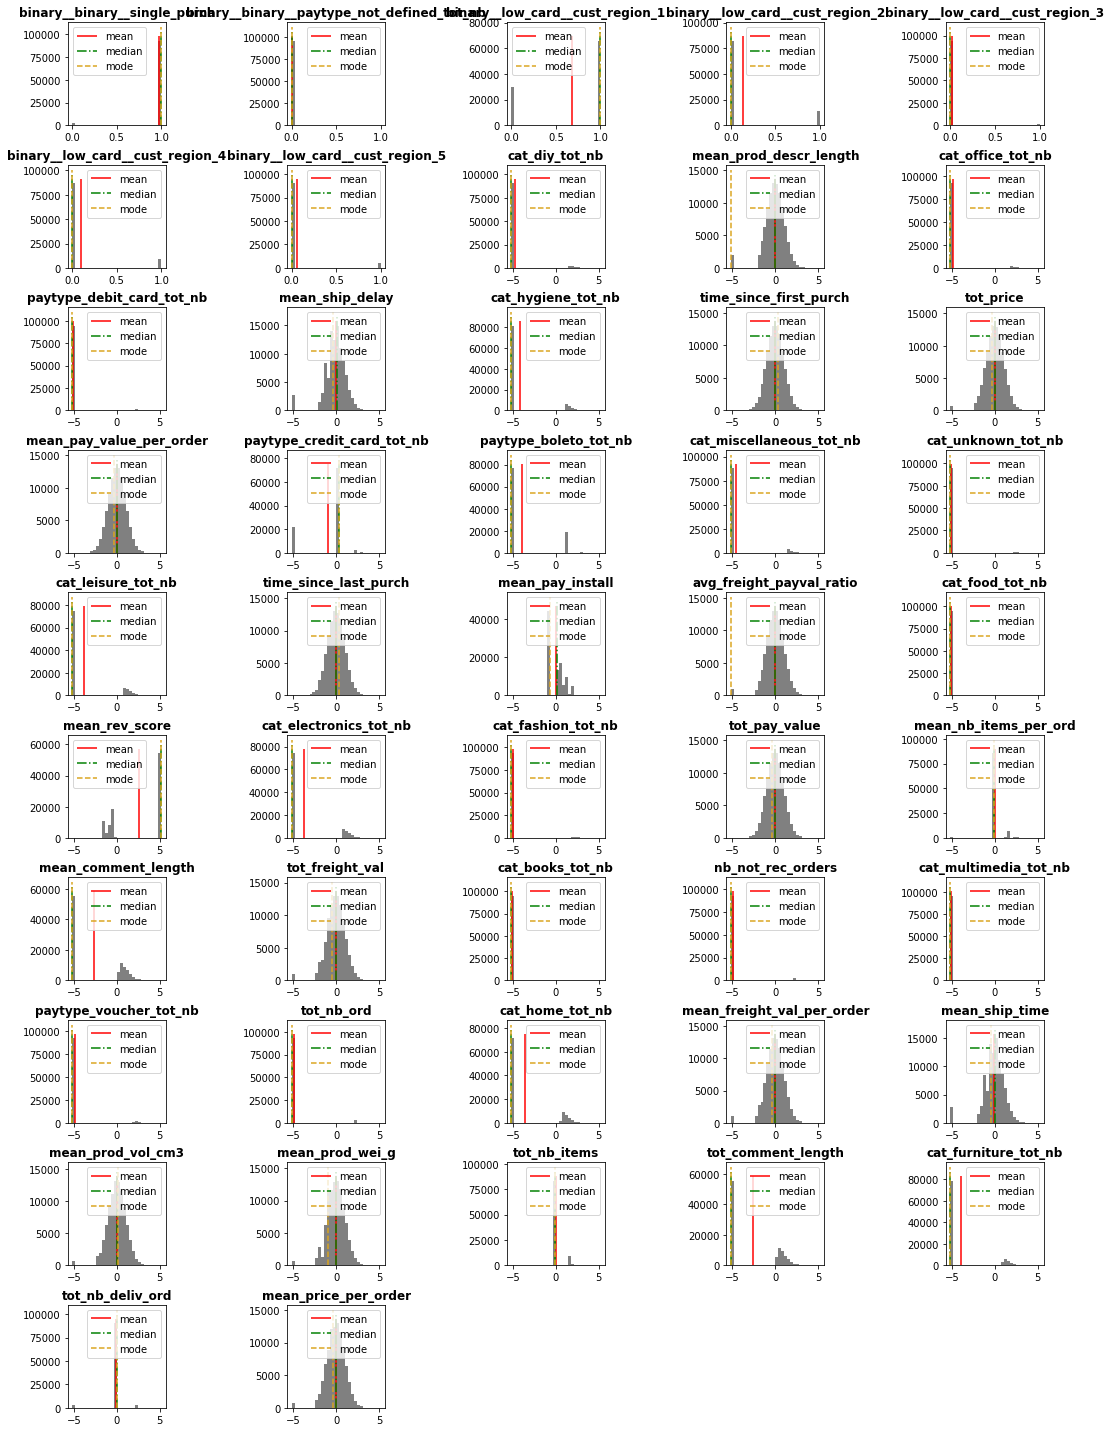

In [ ]:
# Histograms of the transformed data
plot_histograms(df=df1_1_trans, cols=df1_1_trans.columns,
                figsize=(15,20), bins=30, layout=(10,5))

#### All the variable, UMAP 10 comp (df1_2)

In [ ]:
# # Data selection
# df1_2 = df_cust[all_cols]

# # Transformation and encoding
# ct = CustTransformer(strat_low_card='ohe',
#                       strat_quant='none')
# df1_2 = ct.fit_transform(df1_2)

In [ ]:
# from umap import UMAP

# n_comp = 10
# umap = UMAP(n_components=n_comp, n_neighbors=15, min_dist=0.1, init='spectral',
#             random_state=14)

# # Fitting the model, projecting data on UMAP axes
# df1_2_trans = pd.DataFrame(umap.fit_transform(df1_2),
#                             index=df1_2.index,
#                             columns=['UMAP'+str(i) for i in range(n_comp)])

In [ ]:
# # Transformation and encoding
# ct = CustTransformer(strat_quant='quant_norm')

# df1_2_trans = ct.fit_transform(df1_2_trans)

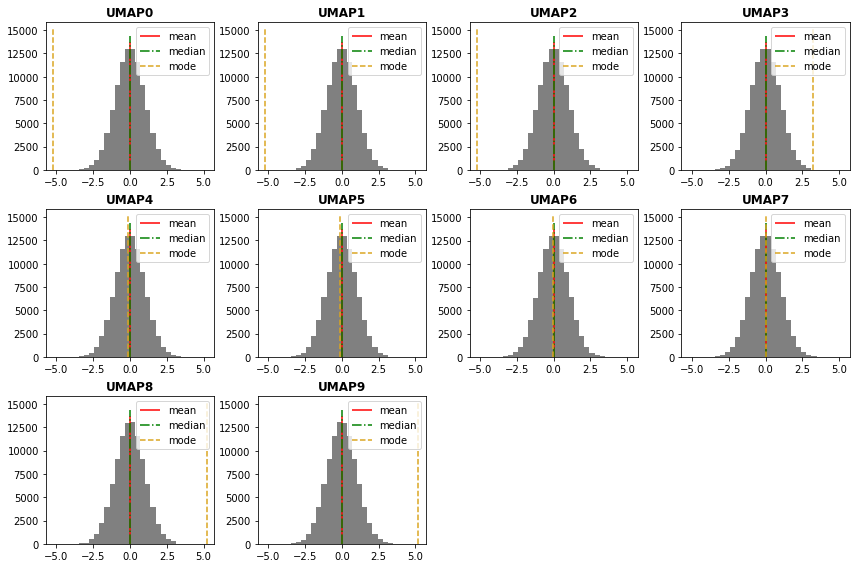

In [ ]:
# # Histograms of the transformed data
# plot_histograms(df=df1_2_trans, cols=df1_2_trans.columns,
#                 figsize=(12,8), bins=30, layout=(3,4))

#### All RFM features (df2_1)

In [ ]:
# Data selection
sel_cols_2_1 = recency_cols\
            + frequency_cols\
            + monetary_cols

df2_1 = df_cust[sel_cols_2_1]

sel_cols_2_1

['time_since_last_purch',
 'time_since_first_purch',
 'tot_nb_deliv_ord',
 'tot_nb_ord',
 'single_purch',
 'mean_nb_items_per_ord',
 'tot_nb_items',
 'mean_freight_val_per_order',
 'tot_freight_val',
 'mean_price_per_order',
 'tot_price',
 'avg_freight_payval_ratio',
 'mean_pay_value_per_order',
 'tot_pay_value']

In [ ]:
# Transformation and encoding
ct = CustTransformer(strat_low_card='ohe',
                     strat_quant='quant_norm')

df2_1_trans = ct.fit_transform(df2_1)

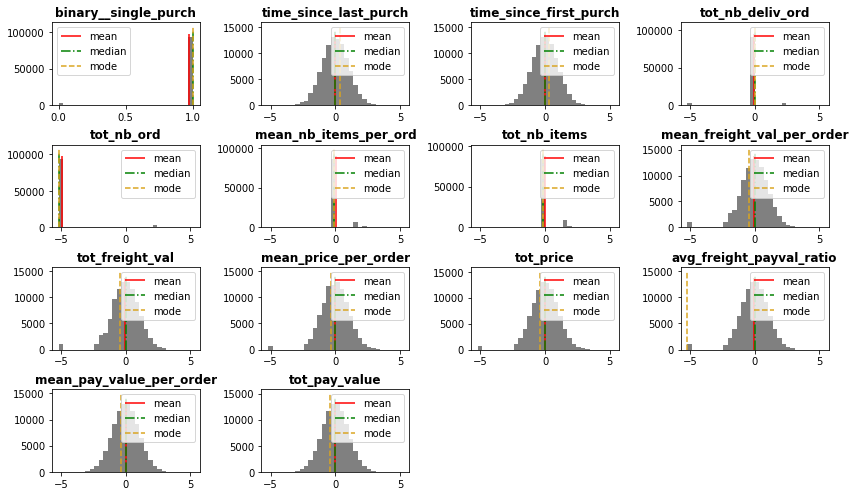

In [ ]:
# Histograms of the transformed data
plot_histograms(df=df2_1_trans, cols=df2_1_trans.columns,
                figsize=(12,7), bins=30, layout=(4,4))

#### All RFM + paytype (df2_2)

In [ ]:
# Data selection
sel_cols_2_2 = recency_cols\
            + frequency_cols\
            + pay_cols\
            + monetary_cols

df2_2 = df_cust[sel_cols_2_2]

sel_cols_2_2

['time_since_last_purch',
 'time_since_first_purch',
 'tot_nb_deliv_ord',
 'tot_nb_ord',
 'single_purch',
 'mean_nb_items_per_ord',
 'tot_nb_items',
 'paytype_not_defined_tot_nb',
 'paytype_boleto_tot_nb',
 'paytype_voucher_tot_nb',
 'paytype_debit_card_tot_nb',
 'paytype_credit_card_tot_nb',
 'mean_pay_install',
 'mean_freight_val_per_order',
 'tot_freight_val',
 'mean_price_per_order',
 'tot_price',
 'avg_freight_payval_ratio',
 'mean_pay_value_per_order',
 'tot_pay_value']

In [ ]:
# Transformation and encoding
ct = CustTransformer(strat_low_card='ohe',
                      strat_quant='quant_norm')

df2_2_trans = ct.fit_transform(df2_2)

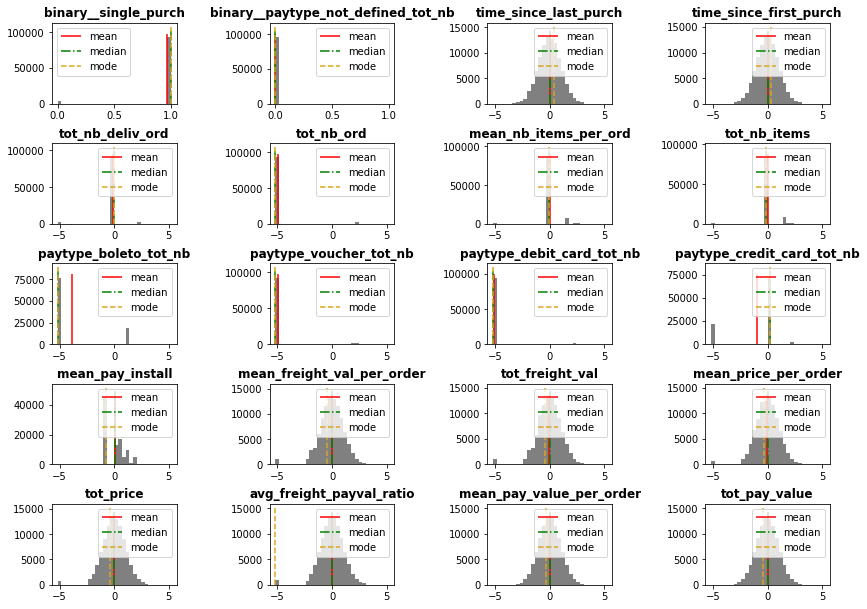

In [ ]:
# Histograms of the transformed data
plot_histograms(df=df2_2_trans, cols=df2_2_trans.columns,
                figsize=(12,10), bins=30, layout=(6,4))

#### Selection RFM features (df2_3)

We want to a a first clustering based on the value, seniority and loyalty of a  customer. These qualities are defined by the typical RFM analysis (Recency, Frequency, Monetary). In our database, we can use the following features:
- Recency: 'time_since_first_purch'
- Monetary: 'tot_price'
- Frequency: 'tot_nb_ord', 'single_purch', 'time_since_last_purch'

NB: We know that the 'Frequency' will be the more difficult to apprehend, since the great majority of the customers had only one order, that's why we keep the three features as they are.

In [ ]:
# Data selection
sel_cols_2_3 = ['tot_nb_ord', 'tot_price',
                'time_since_last_purch', 'time_since_first_purch']

df2_3 = df_cust[sel_cols_2_3]

In [ ]:
# Transformation and encoding
ct = CustTransformer(strat_low_card='ohe',
                      strat_quant='quant_norm')

df2_3_trans = ct.fit_transform(df2_3)

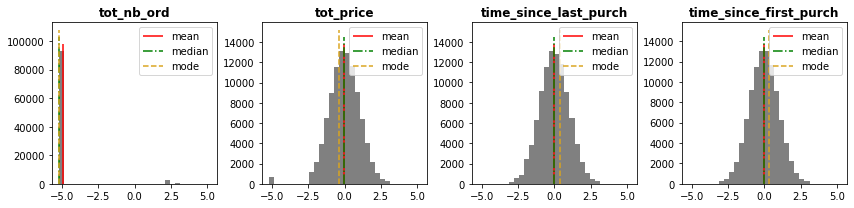

In [ ]:
# Histograms of the transformed data
plot_histograms(df=df2_3_trans, cols=df2_3_trans.columns,
                figsize=(12,3), bins=30, layout=(1,4))

#### Product spec, review and monetary (df3_1)

In [ ]:
# Data selection
sel_cols_3_1 = list(set(prod_spec_cols\
                + satisf_cols\
                + monetary_cols))

df3_1 = df_cust[sel_cols_3_1]

sel_cols_3_1

['mean_ship_time',
 'mean_prod_vol_cm3',
 'mean_prod_descr_length',
 'tot_comment_length',
 'tot_freight_val',
 'mean_ship_delay',
 'avg_freight_payval_ratio',
 'nb_not_rec_orders',
 'mean_rev_score',
 'tot_price',
 'mean_prod_wei_g',
 'mean_pay_value_per_order',
 'tot_pay_value',
 'mean_price_per_order',
 'mean_freight_val_per_order',
 'mean_comment_length']

In [ ]:
# Transformation and encoding
ct = CustTransformer(strat_low_card='ohe',
                      strat_quant='quant_norm')

df3_1_trans = ct.fit_transform(df3_1)

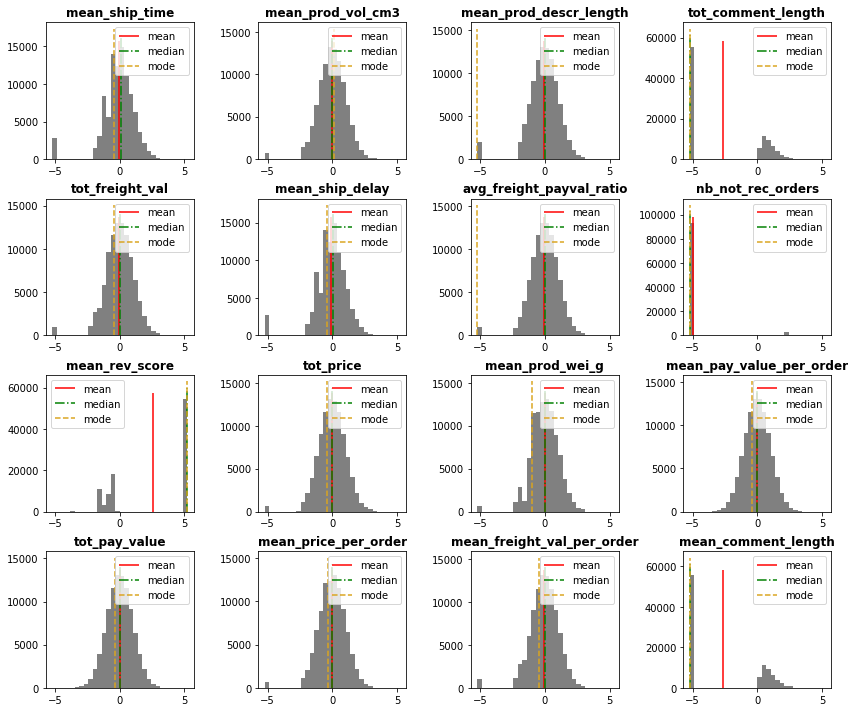

In [ ]:
# Histograms of the transformed data
plot_histograms(df=df3_1_trans, cols=df3_1_trans.columns,
                figsize=(12,10), bins=30, layout=(4,4))

#### Product spec, satisfaction and monetary + category (df3_2)

In [ ]:
# Data selection
sel_cols_3_2 = list(set(prod_spec_cols\
                + cat_cols\
                + satisf_cols\
                + monetary_cols))

df3_2 = df_cust[sel_cols_3_2]

sel_cols_3_2

['cat_diy_tot_nb',
 'mean_prod_descr_length',
 'cat_office_tot_nb',
 'mean_ship_delay',
 'cat_hygiene_tot_nb',
 'tot_price',
 'mean_pay_value_per_order',
 'cat_miscellaneous_tot_nb',
 'cat_unknown_tot_nb',
 'cat_leisure_tot_nb',
 'avg_freight_payval_ratio',
 'cat_food_tot_nb',
 'mean_rev_score',
 'cat_electronics_tot_nb',
 'cat_fashion_tot_nb',
 'tot_pay_value',
 'mean_comment_length',
 'tot_freight_val',
 'cat_books_tot_nb',
 'nb_not_rec_orders',
 'cat_multimedia_tot_nb',
 'cat_home_tot_nb',
 'mean_freight_val_per_order',
 'mean_ship_time',
 'mean_prod_vol_cm3',
 'mean_prod_wei_g',
 'cat_furniture_tot_nb',
 'tot_comment_length',
 'mean_price_per_order']

In [ ]:
# Transformation and encoding
ct = CustTransformer(strat_low_card='ohe',
                      strat_quant='quant_norm')

df3_2_trans = ct.fit_transform(df3_2)

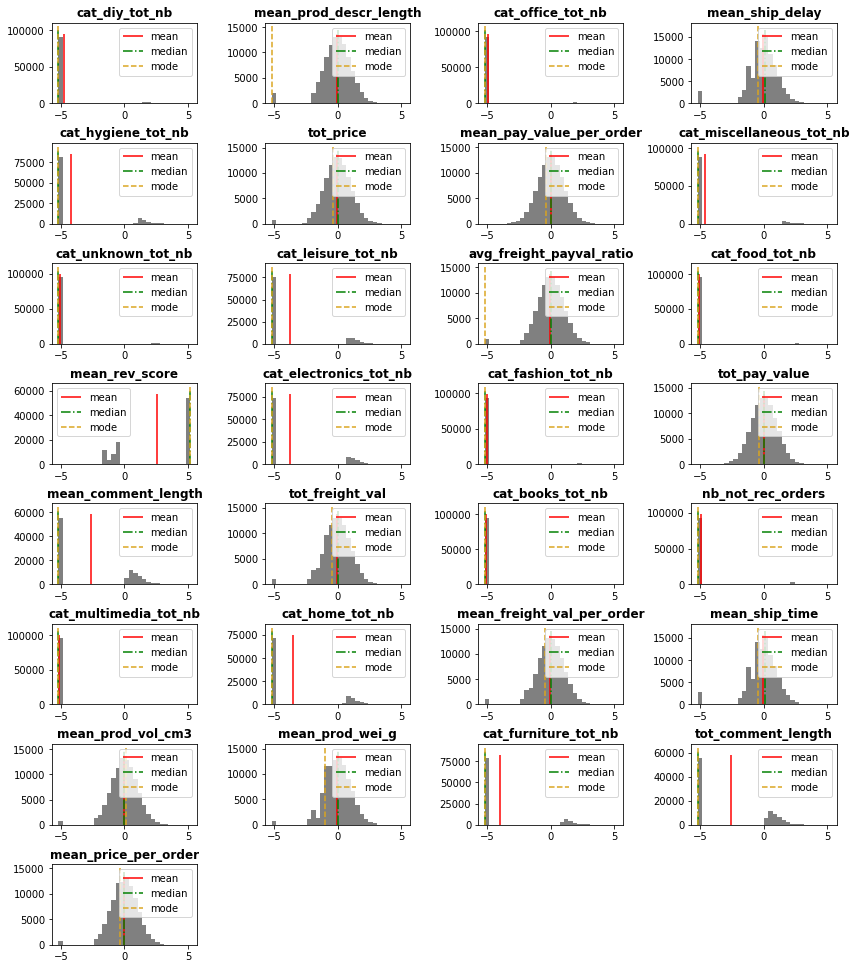

In [ ]:
# Histograms of the transformed data
plot_histograms(df=df3_2_trans, cols=df3_2_trans.columns,
                figsize=(12,15), bins=30, layout=(9,4))

#### Selection Product spec, review and monetary (df3_3)


In [ ]:
# Data selection
sel_cols_3_3 = ['mean_pay_value_per_order', 'avg_freight_payval_ratio', 
                'nb_not_rec_orders', 'mean_prod_wei_g', 'mean_comment_length', 
                'mean_rev_score', 'mean_prod_vol_cm3', 'mean_prod_descr_length',
                'tot_price', 'tot_comment_length', 'mean_ship_delay']

df3_3 = df_cust[sel_cols_3_3]

In [ ]:
# Transformation and encoding
ct = CustTransformer(strat_low_card='ohe',
                      strat_quant='quant_norm')

df3_3_trans = ct.fit_transform(df3_3)

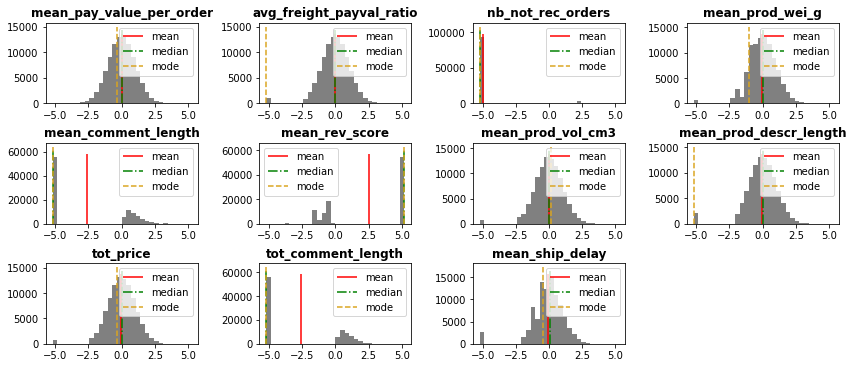

In [ ]:
# Histograms of the transformed data
plot_histograms(df=df3_3_trans, cols=df3_3_trans.columns,
                figsize=(12,15), bins=30, layout=(9,4))